In [29]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## Loading Data

Counting neutral/no occlusion images...
Neutral images: 5136
Counting sunglasses images...
Sunglasses images: 2374
Counting masked images...
Masked images: 317
Counting total images...
Total images: 7827


Processing 'neutral' images:   4%|█▎                            | 217/5136 [00:00<00:05, 916.93it/s]


===== Random Neutral Image Samples (Original Colors) =====


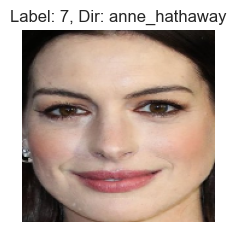

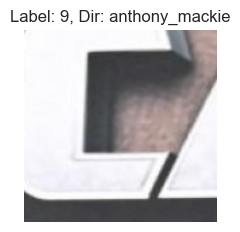

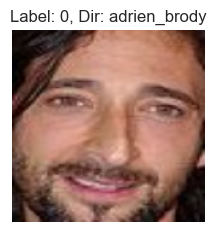

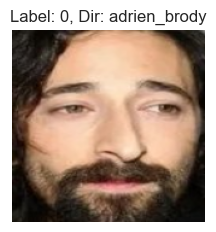

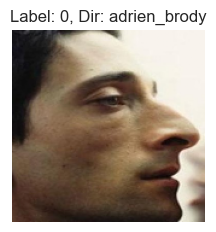

Processing 'sunglasses' images:   4%|█                          | 94/2374 [00:00<00:00, 3232.21it/s]


[ERROR] Failed to load image images\sunglasses\amber_heard_wearing_sunglasses\000013.jpg: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

===== Random Sunglasses Image Samples (Original Colors) =====


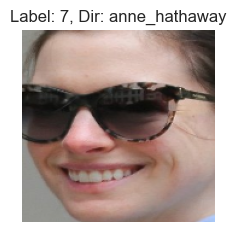

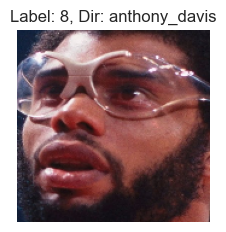

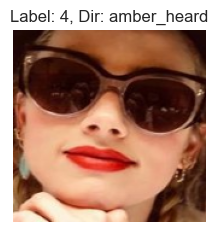

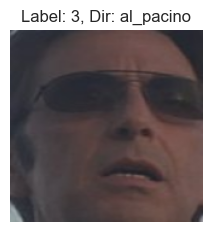

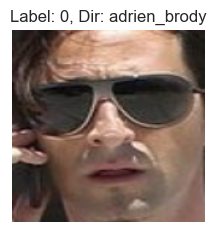

[ERROR] Failed to load image images\masked\amy_klobuchar_wearing_mask\000004.jpg: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

[ERROR] Failed to load image images\masked\anthony_davis_wearing_mask\000001.jpg: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

[ERROR] Failed to load image images\masked\bill_gates_wearing_mask\000002.jpg: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



Processing 'masked' images:   9%|██▋                            | 28/317 [00:00<00:00, 27135.05it/s]

===== Random Masked Image Samples (Original Colors) =====


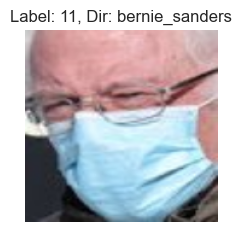

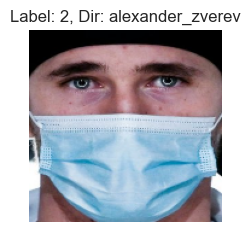

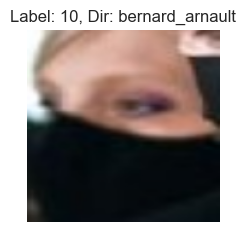

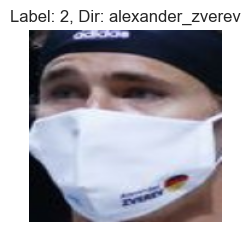

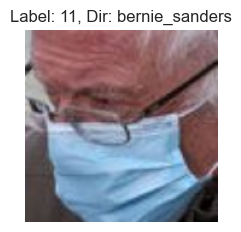

Dataset Loaded: 0 images, 0 unique labels.


In [30]:
# Configuration
NUM_CLASSES_SUBSET = 50
IMG_SIZE = 160
base_dir = "images"
occlusion_types = ["masked", "sunglasses", "neutral"]

print("Counting neutral/no occlusion images...")
neutral_images_count = sum(
    len(os.listdir(os.path.join(base_dir, "neutral", person_dir)))
    for person_dir in os.listdir(os.path.join(base_dir, "neutral"))
    if os.path.isdir(os.path.join(base_dir, "neutral", person_dir))
)
print(f"Neutral images: {neutral_images_count}")

print("Counting sunglasses images...")
sunglasses_images_count = sum(
    len(os.listdir(os.path.join(base_dir, "sunglasses", person_dir)))
    for person_dir in os.listdir(os.path.join(base_dir, "sunglasses"))
    if os.path.isdir(os.path.join(base_dir, "sunglasses", person_dir))
)
print(f"Sunglasses images: {sunglasses_images_count}")

print("Counting masked images...")
masked_images_count = sum(
    len(os.listdir(os.path.join(base_dir, "masked", person_dir)))
    for person_dir in os.listdir(os.path.join(base_dir, "masked"))
    if os.path.isdir(os.path.join(base_dir, "masked", person_dir))
)
print(f"Masked images: {masked_images_count}")

print("Counting total images...")
total_images = sum(
    len(os.listdir(os.path.join(base_dir, occlusion_type, person_dir)))
    for occlusion_type in occlusion_types if os.path.exists(os.path.join(base_dir, occlusion_type))
    for person_dir in os.listdir(os.path.join(base_dir, occlusion_type))
    if os.path.isdir(os.path.join(base_dir, occlusion_type, person_dir))
)

print(f"Total images: {total_images}")

# Containers for data
images, labels = [], []
label_names = {}

# Function to process a single image
def process_image(img_path, label):
    try:
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Load as color (BGR)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize image
        img = img.astype("float32") / 255.0  # Normalize
        return img, label
    except Exception as e:
        return None, None

def load_images_by_type(occlusion_type, total_images, max_persons=None):
    images = []
    labels = []

    occlusion_path = os.path.join(base_dir, occlusion_type)

    if not os.path.exists(occlusion_path):
        print(f"[WARNING] Directory {occlusion_path} does not exist. Skipping.")
        return images, labels

    tasks = []

    # --- Get all person dirs, optionally limit to subset ---
    all_person_dirs = [d for d in os.listdir(occlusion_path) if os.path.isdir(os.path.join(occlusion_path, d))]
    all_person_dirs = all_person_dirs[:NUM_CLASSES_SUBSET]

    with ThreadPoolExecutor(max_workers=8) as executor:
        for person_dir in all_person_dirs:
            person_path = os.path.join(occlusion_path, person_dir)

            # Clean labels
            clean_label = person_dir.replace("_wearing_sunglasses", "").replace("_wearing_mask", "")
            
            if clean_label not in label_names:
                label_names[clean_label] = len(label_names)

            label = label_names[clean_label]

            for img_file in os.listdir(person_path):
                if img_file.endswith('.jpg'):
                    img_path = os.path.join(person_path, img_file)
                    tasks.append(executor.submit(process_image, img_path, label))

        for future in tqdm(tasks, total=total_images, desc=f"Processing '{occlusion_type}' images", ncols=100):
            img, label = future.result()
            if img is not None:
                images.append(img)
                labels.append(label)

    return images, labels

# Start loading images
neutral_images, neutral_labels = load_images_by_type("neutral", neutral_images_count)
reverse_label_names = {v: k for k, v in label_names.items()}
num_samples = 5
sample_indices = random.sample(range(len(neutral_images)), num_samples)
print("===== Random Neutral Image Samples =====")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, idx in enumerate(sample_indices):
    img = neutral_images[idx]
    label = neutral_labels[idx]
    ax = axes[i // 5, i % 5]
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(f"Label: {label}\nDir: {reverse_label_names[label]}", fontsize=9)
    ax.axis('off')
plt.tight_layout()
plt.show()
    
sunglasses_images, sunglasses_labels = load_images_by_type("sunglasses", sunglasses_images_count)
reverse_label_names = {v: k for k, v in label_names.items()}
sample_indices = random.sample(range(len(sunglasses_images)), num_samples)
print("===== Random Sunglasses Image Samples =====")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, idx in enumerate(sample_indices):
    img = sunglasses_images[idx]
    label = sunglasses_labels[idx]
    ax = axes[i // 5, i % 5]
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(f"Label: {label}\nDir: {reverse_label_names[label]}", fontsize=9)
    ax.axis('off')
plt.tight_layout()
plt.show()


masked_images, masked_labels = load_images_by_type("masked", masked_images_count)
reverse_label_names = {v: k for k, v in label_names.items()}
sample_indices = random.sample(range(len(masked_images)), num_samples)
print("===== Random Masked Image Samples =====")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, idx in enumerate(sample_indices):
    img = masked_images[idx]
    label = masked_labels[idx]
    ax = axes[i // 5, i % 5]
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(f"Label: {label}\nDir: {reverse_label_names[label]}", fontsize=9)
    ax.axis('off')
plt.tight_layout()
plt.show()


print(f"Dataset Loaded: {len(masked_images) + len(sunglasses_images) + len(sample_indices)} images, {len(label_names)} unique labels.")


## Train - Test Split

In [31]:
def split_dataset(images, labels, occlusion_type):
    X_train, X_test, y_train, y_test = train_test_split(
        np.array(images), np.array(labels), test_size=0.2, random_state=42
    )
    print(f"\n{occlusion_type.capitalize()} data: {X_train.shape[0]} train samples, {X_test.shape[0]} test samples.")
    return X_train, X_test, y_train, y_test

X_train_neutral, X_test_neutral, y_train_neutral, y_test_neutral = split_dataset(neutral_images, neutral_labels, "neutral")
X_train_sunglasses, X_test_sunglasses, y_train_sunglasses, y_test_sunglasses = split_dataset(sunglasses_images, sunglasses_labels, "sunglasses")
X_train_masked, X_test_masked, y_train_masked, y_test_masked = split_dataset(masked_images, masked_labels, "masked")

#Combine Training Sets
X_train = np.concatenate([X_train_neutral, X_train_sunglasses, X_train_masked], axis=0)
y_train = np.concatenate([y_train_neutral, y_train_sunglasses, y_train_masked], axis=0)

X_test = np.concatenate([X_test_neutral, X_test_sunglasses, X_test_masked], axis=0)
y_test = np.concatenate([y_test_neutral, y_test_sunglasses, y_test_masked], axis=0)


Neutral data: 173 train samples, 44 test samples.

Sunglasses data: 74 train samples, 19 test samples.

Masked data: 20 train samples, 5 test samples.


## Datagen Augmentation

In [32]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)
datagen.fit(X_train)


## Building Models
Model A: A simple CNN with two convolutional layers.
Model B: A deeper CNN with three convolutional layers and dropout.
Model C: A variant with more filters and batch normalization.

In [33]:
num_classes = len(label_names)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

C:\Users\grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 79, 79, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,404,752 (20.62 MB)

 Trainable params: 5,404,304 (20.62 MB)

 Non-trainable params: 448 (1.75 KB)

## Training Models

In [34]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_test, y_test)
)

C:\Users\grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step - accuracy: 0.1237 - loss: 8.2535 - val_accuracy: 0.1618 - val_loss: 3.0276
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 282ms/step - accuracy: 0.2487 - loss: 10.1257 - val_accuracy: 0.1176 - val_loss: 2.9238
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step - accuracy: 0.2974 - loss: 8.8497 - val_accuracy: 0.1176 - val_loss: 3.0459
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 301ms/step - accuracy: 0.2693 - loss: 8.2890 - val_accuracy: 0.1176 - val_loss: 3.3792
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step - accuracy: 0.3273 - loss: 8.4769 - val_accuracy: 0.1029 - val_loss: 3.2575
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 306ms/step - accuracy: 0.3498 - loss: 8.4939 - val_accuracy: 0.1618 - val_loss: 3.4064
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 333ms/step - accuracy: 0.3063 - loss: 6.7882 - val_accuracy: 0.1029 - val_loss: 3.6512
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 353ms/step - accuracy: 0.3432 - loss: 5.8544 - val_accuracy: 0.1471 - val_loss

## Analysis

Test Accuracy: 0.132, Test Loss: 3.223
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.08      1.00      0.14         4
           2       0.50      0.25      0.33         4
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00         8
           9       0.44      0.67      0.53         6
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         1

    accuracy                           0.13        68
   macro avg       0.08      0.15      0.08        68
weighted avg       0.07      0.13

C:\Users\grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

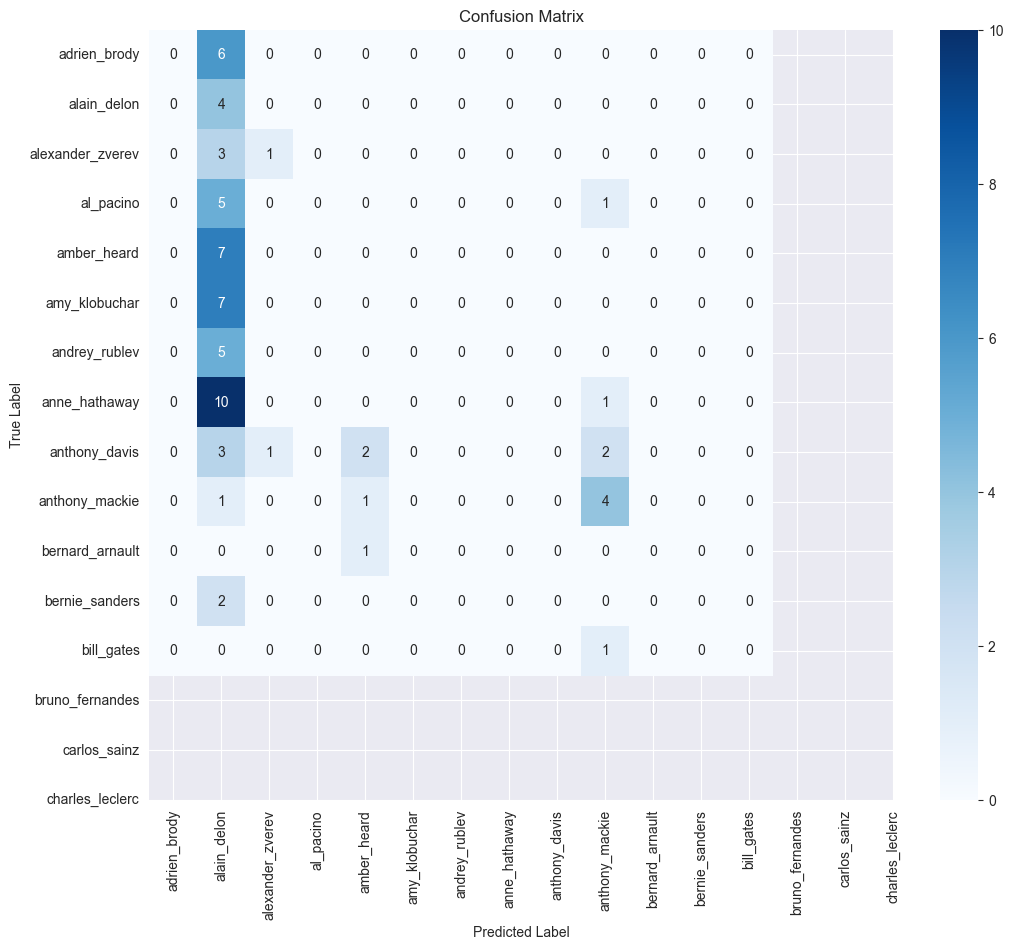

In [35]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.3f}, Test Loss: {test_loss:.3f}")

# Predictions and classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[k for k in label_names],
            yticklabels=[k for k in label_names])
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()


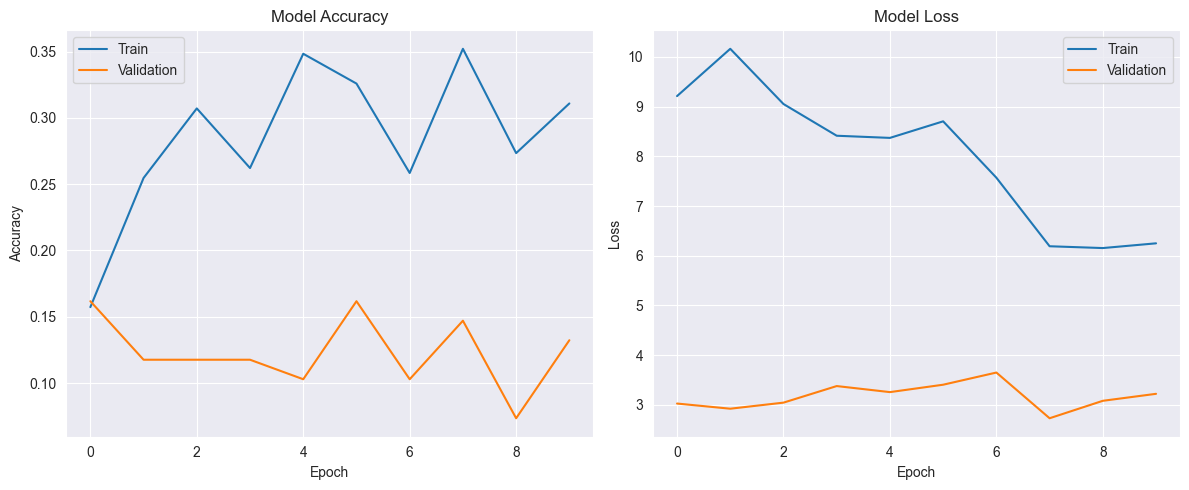

In [36]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
